<img src="assets/logo.png" width="300px">

# Supplementary 4 - Independent Testing and Ecological Application
**BoutScout: A Deep Learning Framework for Automatic Detection of Incubation Events in Avian Nests Using Temperature Time Series**

Author: [Jorge Lizarazo](https://www.researchgate.net/profile/Jorge-Lizarazo-Borrero?ev=hdr_xprf)

This supplementary notebook demonstrates how the final BoutScout model performs when applied to new, independent nest temperature datasets. These data were not used during model training or validation and represent recordings from two sister species, *Myioborus miniatus* and *M. melanocephalus*, collected across different elevations in Colombia and Peru.

The notebook includes batch inference using the exported PyTorch model, post-processing of per-minute predictions, visualization of predicted behavioral sequences against raw temperature curves, and summary statistics for daily incubation patterns. Finally, it merges the predicted behavior with ecological metadata (e.g., elevation, egg mass, locality), enabling further ecological analyses and interpretation. This testing phase confirms the model's generalization capacity and highlights its practical utility for behavioral ecology research in the field.


**Year:** 2025

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib

# Confirma backend clásico
print("Backend activo:", matplotlib.get_backend())

Backend activo: inline


In [2]:

import os
import pandas as pd
import glob
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
folder_path = r"G:/Thesis/Testting/incubation_myioborus/Processed"

In [4]:
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

In [5]:
dataframes = {}

# Leer cada archivo y guardarlo en el diccionario
for file in csv_files:
    file_name = os.path.splitext(os.path.basename(file))[0]
    df = pd.read_csv(file)
    dataframes[file_name] = df

# Ver cuántos archivos se importaron y mostrar los nombres
print(f"Se importaron {len(dataframes)} archivos.")
print("Archivos importados:")
for name in dataframes:
    print(name)

Se importaron 47 archivos.
Archivos importados:
Myioborus_melanocephalus_TU1a_DOR08_NEST_processed
Myioborus_melanocephalus_W1a_JAB08_EGG_processed
Myioborus_melanocephalus_w1a_nap08_EGG_processed
Myioborus_melanocephalus_W1a_wjm08_processed
Myioborus_melanocephalus_W1b_DOR11_EGG_processed
Myioborus_melanocephalus_W1b_JAB08_processed
Myioborus_melanocephalus_W1c_DOR11_EGG_processed
Myioborus_miniatus_SP12a_RVA10_EGG_processed
Myioborus_miniatus_SP12b_RVA10_EGG_processed
Myioborus_miniatus_SP12c_RVA10_EGG_processed
Myioborus_miniatus_SP1a_MCE08_EGG_processed
Myioborus_miniatus_SP1b_MCE08_EGGbutbadtemp_processed
Myioborus_miniatus_SP1_DAR11_EGG_processed
Myioborus_miniatus_SP2a_DOR09_EGG_processed
Myioborus_miniatus_SP2b_DOR09_EGG_processed
Myioborus_miniatus_SPR01_JCB09_EGG_processed
Myioborus_miniatus_TA02a_CA15_processed
Myioborus_miniatus_TA02a_RA15_processed
Myioborus_miniatus_TA04A_MB15_processed
Myioborus_miniatus_TA04a_RVA14_processed
Myioborus_miniatus_TA04B_MB15_processed
Myiob

In [6]:
# Diccionarios para almacenar los datasets por tipo
datasets_egg = {}
datasets_nest = {}

for file in csv_files:
    df = pd.read_csv(file)
    file_name = os.path.splitext(os.path.basename(file))[0]

    columns_lower = df.columns.str.lower()

    has_nest = any('nest' in col for col in columns_lower)
    has_egg = any('egg' in col for col in columns_lower)

    if has_nest and has_egg:
        # Identificar columnas
        id_cols = [col for col in df.columns if col in ['#', 'Date-time']]
        egg_cols = [col for col in df.columns if 'egg' in col.lower()]
        nest_cols = [col for col in df.columns if 'nest' in col.lower()]
        other_cols = [col for col in df.columns if col not in id_cols + egg_cols + nest_cols]

        # Crear DataFrames reordenados
        df_egg = df[id_cols + egg_cols + other_cols].copy()
        df_nest = df[id_cols + nest_cols + other_cols].copy()

        datasets_egg[file_name + "_EGG"] = df_egg
        datasets_nest[file_name + "_NEST"] = df_nest

    elif has_egg:
        id_cols = [col for col in df.columns if col in ['#', 'Date-time']]
        egg_cols = [col for col in df.columns if 'egg' in col.lower()]
        other_cols = [col for col in df.columns if col not in id_cols + egg_cols]
        df_egg = df[id_cols + egg_cols + other_cols].copy()
        datasets_egg[file_name] = df_egg

    elif has_nest:
        datasets_nest[file_name] = df

    else:
        print(f"Archivo sin columnas 'EGG' ni 'NEST': {file_name}")

# Ver resumen
print(f"Archivos con datos EGG: {len(datasets_egg)}")
print(f"Archivos con datos NEST: {len(datasets_nest)}")

Archivos con datos EGG: 15
Archivos con datos NEST: 47


In [7]:
datasets_egg

{'Myioborus_melanocephalus_W1a_JAB08_EGG_processed_EGG':          #         Date-time     egg  Ambient
 0        2   11/19/2008 8:04  21.390   32.665
 1        3   11/19/2008 8:05  12.751   12.703
 2        4   11/19/2008 8:06  11.977   12.678
 3        5   11/19/2008 8:07  10.883   12.437
 4        6   11/19/2008 8:08   8.941   12.461
 ...    ...               ...     ...      ...
 2995  2997   11/21/2008 9:59  46.067   70.626
 2996  2998  11/21/2008 10:00  45.908   72.119
 2997  2999  11/21/2008 10:01  45.342   69.792
 2998  3000  11/21/2008 10:02  46.162   71.480
 2999  3001  11/21/2008 10:03   5.693   44.411
 
 [3000 rows x 4 columns],
 'Myioborus_melanocephalus_w1a_nap08_EGG_processed_EGG':            #        Date-time     egg  Ambient
 0          2  10/22/2008 9:01  13.810   16.773
 1          3  10/22/2008 9:02  13.786   17.486
 2          4  10/22/2008 9:03  13.786   17.605
 3          5  10/22/2008 9:04  13.786   17.796
 4          6  10/22/2008 9:05  13.786   16.677
 ...    

In [8]:
datasets_nest

{'Myioborus_melanocephalus_TU1a_DOR08_NEST_processed':            #        Date-time    Nest  Ambient
 0          1  8/14/2008 10:01  17.034   14.625
 1          2  8/14/2008 10:02  17.011   14.601
 2          3  8/14/2008 10:03  17.058   14.649
 3          4  8/14/2008 10:04  17.082   14.625
 4          5  8/14/2008 10:05  17.082   14.673
 ...      ...              ...     ...      ...
 15994  15995  8/25/2008 12:35  17.534   14.098
 15995  15996  8/25/2008 12:36  17.368   13.906
 15996  15997  8/25/2008 12:37  17.415   13.978
 15997  15998  8/25/2008 12:38  17.368   13.978
 15998  15999  8/25/2008 12:39  18.057   13.690
 
 [15999 rows x 4 columns],
 'Myioborus_melanocephalus_W1a_JAB08_EGG_processed_NEST':          #         Date-time    Nest  Ambient
 0        2   11/19/2008 8:04  21.533   32.665
 1        3   11/19/2008 8:05  19.674   12.703
 2        4   11/19/2008 8:06  18.866   12.678
 3        5   11/19/2008 8:07  18.319   12.437
 4        6   11/19/2008 8:08  17.867   12.461
 .

In [9]:
# Combinar datasets y añadir sufijo solo a los verdaderos egg
datasets_combinados = {}

for nombre, df in datasets_egg.items():
    datasets_combinados[nombre + "_soloegg"] = df  # para evitar confusión

for nombre, df in datasets_nest.items():
    datasets_combinados[nombre] = df

In [10]:
batch_size = 16  # <-- asegúrate de mantener esta línea
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the model

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BiLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers,
                                  batch_first=True, bidirectional=True)
        self.fc = torch.nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

modelo_final = BiLSTM(input_size=3, hidden_size=64, num_layers=2, num_classes=3)
modelo_final.load_state_dict(torch.load("modelo_fi_total/modelo_entrenado_final_total.pth", map_location=device))
modelo_final.to(device)
modelo_final.eval()

BiLSTM(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

In [12]:
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

datasets_egg = {}
datasets_nest = {}

for file in csv_files:
    df = pd.read_csv(file)
    file_name = os.path.splitext(os.path.basename(file))[0]
    columns_lower = df.columns.str.lower()

    has_nest = any('nest' in col for col in columns_lower)
    has_egg = any('egg' in col for col in columns_lower)

    id_cols = [col for col in df.columns if col.lower() in ['#', 'date-time']]
    egg_cols = [col for col in df.columns if 'egg' in col.lower()]
    nest_cols = [col for col in df.columns if 'nest' in col.lower()]
    other_cols = [col for col in df.columns if col not in id_cols + egg_cols + nest_cols]

    if has_egg:
        df_egg = df[id_cols + egg_cols + other_cols].copy()
        datasets_egg[file_name + "_soloegg"] = df_egg
    if has_nest:
        df_nest = df[id_cols + nest_cols + other_cols].copy()
        datasets_nest[file_name] = df_nest

# Unir en un solo diccionario con IDs únicos
datasets_combinados = {**datasets_egg, **datasets_nest}

# === Dataset para DataLoader ===
class BloqueDataset(Dataset):
    def __init__(self, bloques):
        self.bloques = bloques
    def __len__(self):
        return len(self.bloques)
    def __getitem__(self, idx):
        return torch.tensor(self.bloques[idx], dtype=torch.float32)

# === División en bloques diarios con hour_sin ===
def dividir_en_bloques(df):
    df['hour_sin'] = np.sin(2 * np.pi * df['tiempo'] / 1440)
    bloques = []
    for i in range(0, len(df), 1440):
        bloque = df.iloc[i:i+1440]
        if len(bloque) == 1440:
            X = bloque[['egg', 'ambient', 'hour_sin']].to_numpy()
            bloques.append(X)
    return np.array(bloques)

In [13]:
resultados = []
batch_size = 16  # Asegúrate de definir esto antes del bucle

for nombre_archivo, df in tqdm(datasets_combinados.items()):
    df.columns = [col.lower() for col in df.columns]

    if 'date-time' in df.columns:
        df = df.rename(columns={'date-time': 'tiempo'})

    if not all(col in df.columns for col in ['tiempo']) or \
       not any(col in df.columns for col in ['egg', 'nest']):
        print(f"❌ Saltando {nombre_archivo} - columnas incompletas")
        continue

    if 'egg' in df.columns:
        df = df[['egg', 'ambient', 'tiempo']]
    elif 'nest' in df.columns:
        df = df[['nest', 'ambient', 'tiempo']]
        df = df.rename(columns={'nest': 'egg'})  # unificar para el modelo

    # Convertir y ordenar por tiempo real
    if not np.issubdtype(df['tiempo'].dtype, np.number):
        df['tiempo'] = pd.to_datetime(df['tiempo'], errors='coerce')
        df = df.dropna(subset=['tiempo'])
        df = df.sort_values('tiempo')  # 🚨 ESTA LÍNEA ES LA CLAVE
        df['tiempo'] = df['tiempo'].dt.hour * 60 + df['tiempo'].dt.minute

    bloques = dividir_en_bloques(df)
    if len(bloques) == 0:
        print(f"⚠️  {nombre_archivo} no tiene bloques completos de 1440 minutos.")
        continue

    dataset = BloqueDataset(bloques)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for i, batch in enumerate(loader):
            batch = batch.to(device)
            salida = modelo_final(batch)
            preds = torch.argmax(salida, dim=2).cpu().numpy()

            for j, pred in enumerate(preds):
                for minuto, etiqueta in enumerate(pred):
                    resultados.append({
                        "archivo": nombre_archivo,
                        "dia": i * batch_size + j,
                        "minuto": minuto,
                        "prediccion": int(etiqueta)
                    })


 53%|█████▎    | 33/62 [00:03<00:02, 13.39it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_13004\1145630988.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['tiempo'] = pd.to_datetime(df['tiempo'], errors='coerce')
 73%|███████▎  | 45/62 [00:05<00:01, 10.57it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_13004\1145630988.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['tiempo'] = pd.to_datetime(df['tiempo'], errors='coerce')
 97%|█████████▋| 60/62 [00:07<00:00, 11.05it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_13004\1145630988.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, pleas

In [14]:
import random


In [15]:
def plot_prediccion_con_temperatura(df_resultados, datasets_combinados):
    # Elegir aleatoriamente un archivo y un día válido
    archivos_validos = df_resultados['archivo'].unique()
    archivo_id = random.choice(archivos_validos)
    dias_validos = df_resultados[df_resultados['archivo'] == archivo_id]['dia'].unique()
    dia = random.choice(dias_validos)

    # Subset de predicciones
    df_plot = df_resultados[
        (df_resultados['archivo'] == archivo_id) &
        (df_resultados['dia'] == dia)
    ]

    if df_plot.empty or archivo_id not in datasets_combinados:
        print(f"❌ No se encontraron datos para {archivo_id} día {dia}")
        return

    # Cargar el dataframe original y prepararlo
    df = datasets_combinados[archivo_id].copy()
    df.columns = [col.lower() for col in df.columns]
    df = df.rename(columns={'date-time': 'tiempo'} if 'date-time' in df.columns else {})

    if 'nest' in df.columns:
        df = df.rename(columns={'nest': 'egg'})

    # Parsear tiempo
    df['tiempo'] = pd.to_datetime(df['tiempo'], errors='coerce')
    df = df.dropna(subset=['tiempo'])
    df = df.sort_values('tiempo')
    df['tiempo_min'] = df['tiempo'].dt.hour * 60 + df['tiempo'].dt.minute

    # Seleccionar el bloque correspondiente al día
    start_idx = dia * 1440
    end_idx = start_idx + 1440
    if end_idx > len(df):
        print(f"⚠️ Día {dia} excede la cantidad de datos disponibles en {archivo_id}")
        return
    df_day = df.iloc[start_idx:end_idx].copy()
    df_day = df_day.reset_index(drop=True)

    # Añadir predicción
    df_day['prediccion'] = df_plot.sort_values('minuto')['prediccion'].values

    colores = {
        0: '#333E48',  # Nocturnal
        1: '#535AA6',  # Off
        2: '#E28342',  # On
    }


    etiquetas = {
        0: 'Nocturnal',
        1: 'Off',
        2: 'On'
    }

    plt.figure(figsize=(18, 4))
   # plt.plot(df_day['tiempo_min'], df_day['egg'], label="Temperatura Egg", color='black', alpha=0.4)

    for clase in df_day['prediccion'].unique():
        mask = df_day['prediccion'] == clase
        plt.scatter(df_day.loc[mask, 'tiempo_min'], df_day.loc[mask, 'egg'],
                    color=colores[clase], label=etiquetas[clase], s=10)

    plt.title(f"Archivo: {archivo_id} - Día {dia}")
    plt.xlabel("Minuto del día")
    plt.ylabel("Temperatura (°C)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [16]:
df_resultados = pd.DataFrame(resultados)

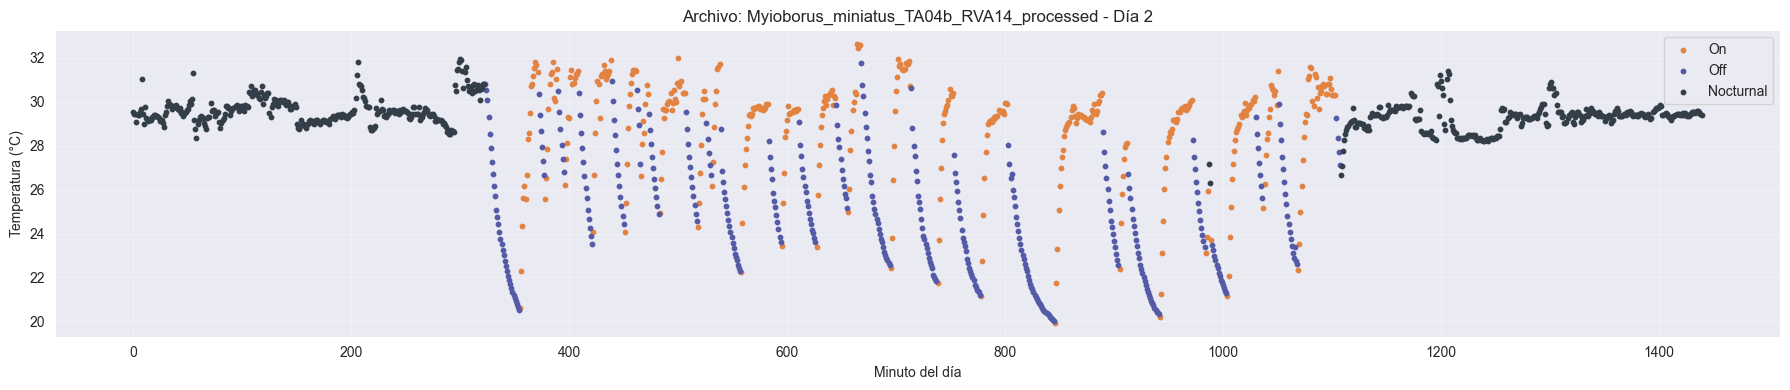

In [17]:

plot_prediccion_con_temperatura(df_resultados, datasets_combinados)

In [18]:
df_resultados

,archivo,dia,minuto,prediccion
0,Myioborus_melanocephalus_W1a_JAB08_EGG_process...,0,0,2
1,Myioborus_melanocephalus_W1a_JAB08_EGG_process...,0,1,1
2,Myioborus_melanocephalus_W1a_JAB08_EGG_process...,0,2,1
3,Myioborus_melanocephalus_W1a_JAB08_EGG_process...,0,3,1
4,Myioborus_melanocephalus_W1a_JAB08_EGG_process...,0,4,1
...,...,...,...,...
472315,Myoburus_miniatus_TA11a_SF15_processed,1,1435,1
472316,Myoburus_miniatus_TA11a_SF15_processed,1,1436,1
472317,Myoburus_miniatus_TA11a_SF15_processed,1,1437,1
472318,Myoburus_miniatus_TA11a_SF15_processed,1,1438,1


In [19]:
from scipy.stats import mode
import numpy as np

# Seleccion

In [20]:
import os

#def exportar_graficas_por_dia(df_resultados, datasets_combinados, carpeta_out="G:/Thesis/figures/testing"):
 #   os.makedirs(carpeta_out, exist_ok=True)

 #   archivos_validos = df_resultados['archivo'].unique()

#    for archivo_id in archivos_validos:
     #   dias_validos = df_resultados[df_resultados['archivo'] == archivo_id]['dia'].unique()

     #   for dia in sorted(dias_validos):
      #      df_plot = df_resultados[
      #          (df_resultados['archivo'] == archivo_id) &
      #          (df_resultados['dia'] == dia)
      #      ]

      #      if df_plot.empty or archivo_id not in datasets_combinados:
      #          continue

     #       df = datasets_combinados[archivo_id].copy()
     #       df.columns = [col.lower() for col in df.columns]
     #       df = df.rename(columns={'date-time': 'tiempo'} if 'date-time' in df.columns else {})
    #        if 'nest' in df.columns:
    #            df = df.rename(columns={'nest': 'egg'})

    #        df['tiempo'] = pd.to_datetime(df['tiempo'], errors='coerce')
    #        df = df.dropna(subset=['tiempo'])
    #        df = df.sort_values('tiempo')
    #        df['tiempo_min'] = df['tiempo'].dt.hour * 60 + df['tiempo'].dt.minute

    #        start_idx = dia * 1440
    #        end_idx = start_idx + 1440
   #         if end_idx > len(df):
   #             continue

  #          df_day = df.iloc[start_idx:end_idx].copy().reset_index(drop=True)
   #         df_day['prediccion'] = df_plot.sort_values('minuto')['prediccion'].values

 #           colores = {0: '#E28342', 1: '#535AA6', 2: '#333E48'}
 #           etiquetas = {0: 'Nocturnal', 1: 'Off', 2: 'On'}

#            fig, ax = plt.subplots(figsize=(18, 4))
#            for clase in df_day['prediccion'].unique():
#                mask = df_day['prediccion'] == clase
#                ax.scatter(df_day.loc[mask, 'tiempo_min'], df_day.loc[mask, 'egg'],
 #                          color=colores[clase], label=etiquetas[clase], s=10)

#            ax.set_title(f"{archivo_id} - Día {dia}")
  #          ax.set_xlabel("Minuto del día")
  #          ax.set_ylabel("Temperatura (°C)")
  #          ax.legend()
  #          ax.grid(alpha=0.3)
  #          fig.tight_layout()

 #           safe_name = f"{archivo_id}_DIA{dia}.png".replace("/", "_").replace("\\", "_")
 #           fig.savefig(os.path.join(carpeta_out, safe_name))
 #           plt.close(fig)

In [21]:
#exportar_graficas_por_dia(df_resultados, datasets_combinados)

In [22]:
from pathlib import Path

In [23]:

carpeta_filtrada = "G:/Thesis/figures/testing"
archivos_ok = os.listdir(carpeta_filtrada)

# Extraer pares (archivo_id, dia) desde nombres como "Myioborus_minia_DIA3.png"
nombres_ok = []
for f in archivos_ok:
    if f.endswith(".png"):
        stem = Path(f).stem
        if "_DIA" in stem:
            archivo, dia = stem.rsplit("_DIA", 1)
            nombres_ok.append((archivo, int(dia)))

set_aceptados = set(nombres_ok)

# Filtrar resultados
df_filtrado = df_resultados[
    df_resultados.apply(lambda row: (row['archivo'], row['dia']) in set_aceptados, axis=1)
]

# Guardar como CSV
df_filtrado.to_csv("resultados_filtrados.csv", index=False)
print(f"✅ Exportado {len(df_filtrado)} filas a 'resultados_filtrados.csv'")

✅ Exportado 388800 filas a 'resultados_filtrados.csv'


In [24]:
filas_completas = []

for (archivo, dia), grupo in df_filtrado.groupby(['archivo', 'dia']):
    if archivo not in datasets_combinados:
        continue

    df_orig = datasets_combinados[archivo].copy()
    df_orig.columns = [col.lower() for col in df_orig.columns]
    df_orig = df_orig.rename(columns={'date-time': 'tiempo'} if 'date-time' in df_orig.columns else {})
    if 'nest' in df_orig.columns:
        df_orig = df_orig.rename(columns={'nest': 'egg'})

    df_orig['tiempo'] = pd.to_datetime(df_orig['tiempo'], errors='coerce')
    df_orig = df_orig.dropna(subset=['tiempo']).sort_values('tiempo')
    df_orig['tiempo_min'] = df_orig['tiempo'].dt.hour * 60 + df_orig['tiempo'].dt.minute

    start_idx = dia * 1440
    end_idx = start_idx + 1440

    if end_idx <= len(df_orig):
        df_day = df_orig.iloc[start_idx:end_idx].copy().reset_index(drop=True)
        df_preds = grupo.sort_values('minuto').reset_index(drop=True)

        # Concatenar columnas
        df_day = df_day.loc[:len(df_preds) - 1]  # recorte de seguridad
        df_preds = df_preds.loc[:len(df_day) - 1]

        df_day['archivo'] = archivo
        df_day['dia'] = dia
        df_day['minuto'] = df_preds['minuto']
        df_day['prediccion'] = df_preds['prediccion']

        filas_completas.append(df_day)

# Combinar todos los días aceptados en un solo DataFrame completo
df_filtrado_completo = pd.concat(filas_completas, ignore_index=True)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13004\439348587.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_orig['tiempo'] = pd.to_datetime(df_orig['tiempo'], errors='coerce')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13004\439348587.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_orig['tiempo'] = pd.to_datetime(df_orig['tiempo'], errors='coerce')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13004\439348587.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_orig['tiempo'] = pd.to_datetime(df_orig['tiempo'], errors='coerce')
C:\Users\ASUS\AppData\Local\Tem

In [25]:
df_filtrado_completo

,#,tiempo,egg,ambient,tiempo_min,archivo,dia,minuto,prediccion
0,1,2008-08-14 10:01:00,17.034,14.625,601,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,0,0,2
1,2,2008-08-14 10:02:00,17.011,14.601,602,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,0,1,1
2,3,2008-08-14 10:03:00,17.058,14.649,603,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,0,2,1
3,4,2008-08-14 10:04:00,17.082,14.625,604,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,0,3,1
4,5,2008-08-14 10:05:00,17.082,14.673,605,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,0,4,1
...,...,...,...,...,...,...,...,...,...
388795,2877,2015-06-07 10:31:00,22.585,24.171,631,Myoburus_miniatus_TA11a_SF15_processed,1,1435,1
388796,2878,2015-06-07 10:32:00,22.537,24.002,632,Myoburus_miniatus_TA11a_SF15_processed,1,1436,1
388797,2879,2015-06-07 10:33:00,22.465,20.412,633,Myoburus_miniatus_TA11a_SF15_processed,1,1437,1
388798,2880,2015-06-07 10:34:00,22.441,20.793,634,Myoburus_miniatus_TA11a_SF15_processed,1,1438,1


In [26]:
def graficar_dia_aleatorio(df_filtrado_completo):
    archivo = random.choice(df_filtrado_completo['archivo'].unique())
    dias = df_filtrado_completo[df_filtrado_completo['archivo'] == archivo]['dia'].unique()
    dia = random.choice(dias)

    df_dia = df_filtrado_completo[
        (df_filtrado_completo['archivo'] == archivo) &
        (df_filtrado_completo['dia'] == dia)
    ].sort_values('tiempo_min')  # 🚨 ordenar por tiempo real

    colores = {0: '#333E48', 1: '#535AA6', 2: '#E28342'}
    etiquetas = {0: 'Nocturnal', 1: 'Off', 2: 'On'}



    plt.figure(figsize=(18, 5))

    # Línea de fondo de temperatura
    plt.plot(df_dia['tiempo_min'], df_dia['egg'], color='black', alpha=0.3, label='Nest Temp')
    plt.plot(df_dia['tiempo_min'], df_dia['ambient'], color='gray', alpha=0.3, label='Ambient Temp')

    for clase in df_dia['prediccion'].unique():
        mask = df_dia['prediccion'] == clase
        plt.scatter(df_dia.loc[mask, 'tiempo_min'], df_dia.loc[mask, 'egg'],
                    color=colores[clase], label=etiquetas[clase], s=10)

    plt.title(f"{archivo} - Día {dia}")
    plt.xlabel("Minuto del día (desde medianoche)")
    plt.ylabel("Temperatura (°C)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()




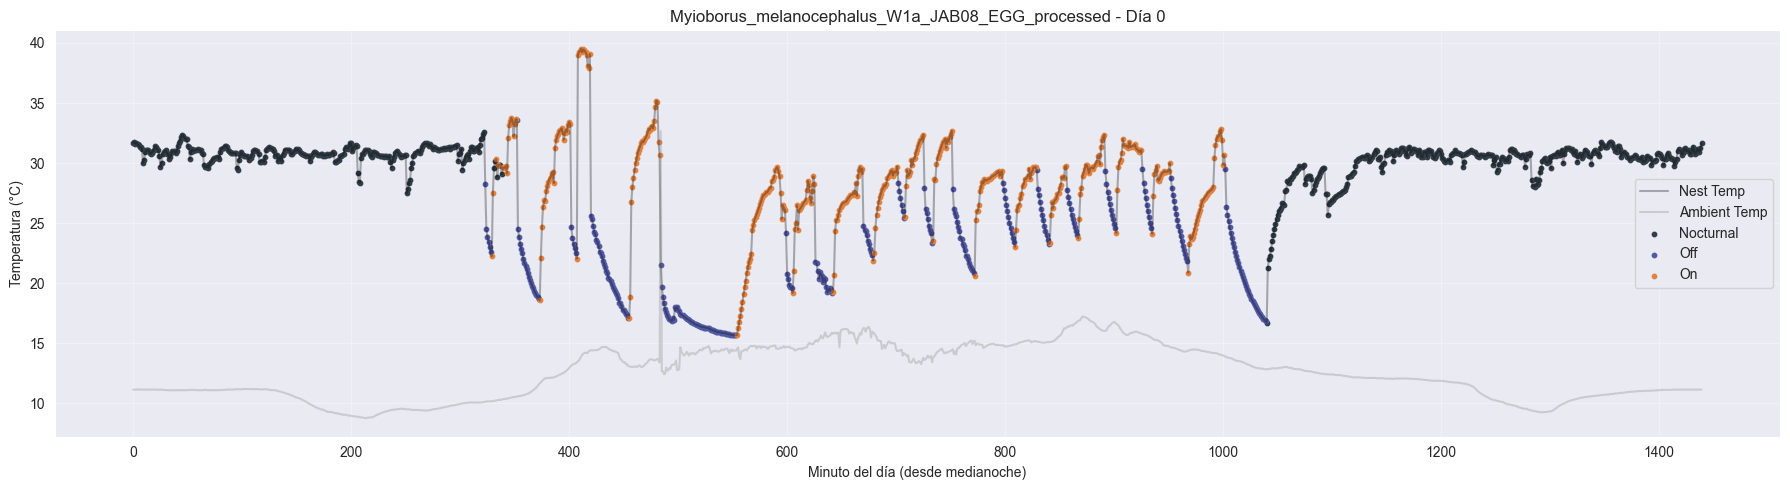

In [27]:
# Ejecutar
graficar_dia_aleatorio(df_filtrado_completo)

In [28]:
def calcular_segmentos(grupo):
    resultado = {
        'archivo': grupo['archivo'].iloc[0],
        'dia': grupo['dia'].iloc[0],
   #     'sensor': grupo['sensor'].iloc[0],
        'total_on': (grupo['prediccion'] == 2).sum(),
        'total_off': (grupo['prediccion'] == 1).sum(),
        'total_nocturnal': (grupo['prediccion'] == 0).sum(),
        'avg_ambient': grupo['ambient'].mean(),       # Promedio temperatura ambiental
        'std_ambient': grupo['ambient'].std()          # Desviación estándar temperatura ambiental
    }

    segmentos_on = []
    segmentos_off = []
    duracion = 1

    for prev, actual in zip(grupo['prediccion'].iloc[:-1], grupo['prediccion'].iloc[1:]):
        if actual == prev:
            duracion += 1
        else:
            if prev == 2:
                segmentos_on.append(duracion)
            elif prev == 1:
                segmentos_off.append(duracion)
            duracion = 1

    if grupo['prediccion'].iloc[-1] == 2:
        segmentos_on.append(duracion)
    elif grupo['prediccion'].iloc[-1] == 1:
        segmentos_off.append(duracion)

    resultado['avg_on'] = np.mean(segmentos_on) if segmentos_on else 0
    resultado['std_on'] = np.std(segmentos_on) if segmentos_on else 0
    resultado['avg_off'] = np.mean(segmentos_off) if segmentos_off else 0
    resultado['std_off'] = np.std(segmentos_off) if segmentos_off else 0

    return pd.Series(resultado)



In [29]:
# Agrupar y aplicar
resumen = df_filtrado_completo.groupby(['archivo', 'dia']).apply(calcular_segmentos).reset_index(drop=True)



C:\Users\ASUS\AppData\Local\Temp\ipykernel_13004\1702988441.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen = df_filtrado_completo.groupby(['archivo', 'dia']).apply(calcular_segmentos).reset_index(drop=True)


In [30]:
# Guardar
# resumen.to_csv("resumen_eventos_por_dia.csv", index=False)
print(resumen.head())

                                             archivo  dia  total_on  \
0  Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...    0       302   
1  Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...    1       251   
2  Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...    3       366   
3  Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...    4       424   
4  Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...    5       442   

   total_off  total_nocturnal  avg_ambient  std_ambient     avg_on     std_on  \
0        373              765    14.991678     1.451811  25.166667  16.435902   
1        403              786    14.515494     1.953879  20.916667  16.398467   
2        295              779    15.042069     0.979089  18.300000  11.528660   
3        250              766    12.982696     1.235762  21.200000  10.888526   
4        231              767    13.744197     0.799791  19.217391   7.923309   

     avg_off    std_off  
0  28.692308  25.583602  
1  28.785714  26.659704  
2  15.52

In [31]:
resumen

,archivo,dia,total_on,total_off,total_nocturnal,avg_ambient,std_ambient,avg_on,std_on,avg_off,std_off
0,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,0,302,373,765,14.991678,1.451811,25.166667,16.435902,28.692308,25.583602
1,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,1,251,403,786,14.515494,1.953879,20.916667,16.398467,28.785714,26.659704
2,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,3,366,295,779,15.042069,0.979089,18.300000,11.528660,15.526316,13.538905
3,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,4,424,250,766,12.982696,1.235762,21.200000,10.888526,11.904762,8.645972
4,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,5,442,231,767,13.744197,0.799791,19.217391,7.923309,10.043478,4.185672
...,...,...,...,...,...,...,...,...,...,...,...
265,Myoborus_ornatus_TA37a_ROAD15_processed,3,276,575,589,14.729694,1.580120,19.714286,13.508878,38.333333,59.475112
266,Myoborus_ornatus_TA3Xa_ROAD15_processed,1,503,470,467,15.729102,2.788907,23.952381,24.032669,47.000000,55.459895
267,Myoborus_ornatus_TA3Xa_ROAD15_processed,3,271,580,589,14.737769,1.562066,20.846154,13.043396,41.428571,74.483665
268,Myoburus_miniatus_TA11a_SF15_processed,0,493,242,705,19.322328,2.585546,35.214286,20.864113,16.133333,9.611567


# Analisis data

In [32]:
# Cargar el archivo de morfología
ruta_morfologia = 'G:/Thesis/Testting/incubation_myioborus/data_add/Datos morfológicos_Nidos_Myioborus.xlsx'
df_morfologia = pd.read_excel(ruta_morfologia)

df_morfologia

,Estacion,Numero_Libreta,Pagina,Año,Familia,Especie,ID_del_Nido,S,W,Elevacion,...,Fecha_puesta_2dohuevo,Fecha_eclosion_1rhuevo,Fecha_eclosion_2dohuevo,Fecha_salida_1rpolluelo,Fecha_salida_2dopolluelo,Notas.1,Fecha_Depredado,Depredador,Fecha.Final.Camara.trampa,Fecha.final.Data.logger
0,Chicoral,1,3,2015,Parulidae,Myioborus_miniatus,CH03_ACC15,NaN,76.5833,2034.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Chicoral,1,31,2015,Parulidae,Myioborus_miniatus,CH06_AMM15,NaN,76.5836,2040.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Chicoral,1,31,2015,Parulidae,Myioborus_miniatus,CH06_AMM15,NaN,76.5836,2040.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Chicoral,1,31,2015,Parulidae,Myioborus_miniatus,CH06_AMM15,NaN,76.5836,2040.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Chicoral,1,31,2015,Parulidae,Myioborus_miniatus,CH06_AMM15,NaN,76.5836,2040.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,Zygia,2,156,2015,Parulidae,Myioborus_miniatus,FA17_MAL15,NaN,76.6643,2324.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
752,Zygia,3,86,2015,Parulidae,Myioborus_miniatus,FA08_MAL15,NaN,76.6663,2289.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
753,Zygia,3,86,2015,Parulidae,Myioborus_miniatus,FA08_MAL15,NaN,76.6663,2289.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
754,Zygia,NaN,64,2018,Parulidae,Myioborus_miniatus,FA04_MMC18,NaN,NaN,2242.661538,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
resumen

,archivo,dia,total_on,total_off,total_nocturnal,avg_ambient,std_ambient,avg_on,std_on,avg_off,std_off
0,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,0,302,373,765,14.991678,1.451811,25.166667,16.435902,28.692308,25.583602
1,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,1,251,403,786,14.515494,1.953879,20.916667,16.398467,28.785714,26.659704
2,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,3,366,295,779,15.042069,0.979089,18.300000,11.528660,15.526316,13.538905
3,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,4,424,250,766,12.982696,1.235762,21.200000,10.888526,11.904762,8.645972
4,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,5,442,231,767,13.744197,0.799791,19.217391,7.923309,10.043478,4.185672
...,...,...,...,...,...,...,...,...,...,...,...
265,Myoborus_ornatus_TA37a_ROAD15_processed,3,276,575,589,14.729694,1.580120,19.714286,13.508878,38.333333,59.475112
266,Myoborus_ornatus_TA3Xa_ROAD15_processed,1,503,470,467,15.729102,2.788907,23.952381,24.032669,47.000000,55.459895
267,Myoborus_ornatus_TA3Xa_ROAD15_processed,3,271,580,589,14.737769,1.562066,20.846154,13.043396,41.428571,74.483665
268,Myoburus_miniatus_TA11a_SF15_processed,0,493,242,705,19.322328,2.585546,35.214286,20.864113,16.133333,9.611567


In [34]:
print(df_morfologia.columns.tolist())

['Estacion', 'Numero_Libreta', 'Pagina', 'Año', 'Familia', 'Especie', 'ID_del_Nido', 'S', 'W', 'Elevacion', 'Fecha_de_encuentro', 'Fecha _eclosion', 'Ultima_fecha_de_actividad', 'Fecha_de_inactividad (Last day nest was checked)', 'Dias_Totales', 'Estado', 'Notas', 'Huevo_o_Polluelo', 'Tipo_de_nido', 'Nido_Int_Largo_mm', 'Nido_Int_Ancho_mm', 'Nido_Int_Espesor_mm', 'Nido_Int_Profundidad_1_mm', 'Nido_Int_Profundidad_2_mm', 'Nido_Ext_Largo_mm', 'Nido_Ext_Ancho_mm', 'Nido_Ext_Alto_mm', 'Altura_sobre_el_suelo_cm', 'Nido_peso_Total_g', 'Capa_1_g', 'Capa_2_g', 'Capa_3_g', 'Capa_4_g', 'Material_extra_g', 'ID_del_Huevo', 'Desarrollo huevos', 'Huevo_Largo_mm', 'Huevo_Ancho_mm', 'Huevo_Peso_g', 'Medianas y desviacion 95%', 'Numero_de_Huevos', 'Fecha_de_medición', 'ID_del_Polluelo', 'Individuo', 'Polluelo_Edad_dias', 'Polluelo_Masa_g', 'Polluelo_Tarso_mm', 'Polluelo_Ala_mm', 'Polluelo_Pico_mm', 'Polluelo_Cola_mm', 'Temp_inicial', 'Temp_final', 'Temp_ambiente', 'Todos_los_huevos_eclosionaron', 'Todo

In [35]:
equivalencias = pd.read_csv("resumen_equivalente.csv")
equivalencias

,archivo,equivalente
0,SP12a_RVA10,SP12_RVA10
1,SP12b_RVA10,SP12_RVA10
2,SP12c_RVA10,SP12_RVA10
3,SP1_DAR11,SP1_DAR11
4,SP1_EJWc11,SP1_EJW11
5,SP1b_MCE08,SP1_MCE08
6,SP1d_EJW11,SP1_EJW11
7,SP2a_DOR09,SP2_DOR09
8,SP2b_DOR09,SP2_DOR09
9,SPR01_JCB09,SP1_JCB09


In [36]:

# Hacer una copia
resumen_copy = resumen.copy()

# Agregar columna nido_id extraída del nombre del archivo
def extraer_id_nido(nombre_archivo):
    try:
        partes = nombre_archivo.split("_")
        return "_".join(partes[2:4])  # Ejemplo: TU1a_DOR08
    except:
        return None

resumen_copy['nido_id'] = resumen_copy['archivo'].apply(extraer_id_nido)



In [37]:

resumen_copy

,archivo,dia,total_on,total_off,total_nocturnal,avg_ambient,std_ambient,avg_on,std_on,avg_off,std_off,nido_id
0,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,0,302,373,765,14.991678,1.451811,25.166667,16.435902,28.692308,25.583602,TU1a_DOR08
1,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,1,251,403,786,14.515494,1.953879,20.916667,16.398467,28.785714,26.659704,TU1a_DOR08
2,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,3,366,295,779,15.042069,0.979089,18.300000,11.528660,15.526316,13.538905,TU1a_DOR08
3,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,4,424,250,766,12.982696,1.235762,21.200000,10.888526,11.904762,8.645972,TU1a_DOR08
4,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,5,442,231,767,13.744197,0.799791,19.217391,7.923309,10.043478,4.185672,TU1a_DOR08
...,...,...,...,...,...,...,...,...,...,...,...,...
265,Myoborus_ornatus_TA37a_ROAD15_processed,3,276,575,589,14.729694,1.580120,19.714286,13.508878,38.333333,59.475112,TA37a_ROAD15
266,Myoborus_ornatus_TA3Xa_ROAD15_processed,1,503,470,467,15.729102,2.788907,23.952381,24.032669,47.000000,55.459895,TA3Xa_ROAD15
267,Myoborus_ornatus_TA3Xa_ROAD15_processed,3,271,580,589,14.737769,1.562066,20.846154,13.043396,41.428571,74.483665,TA3Xa_ROAD15
268,Myoburus_miniatus_TA11a_SF15_processed,0,493,242,705,19.322328,2.585546,35.214286,20.864113,16.133333,9.611567,TA11a_SF15


In [38]:

print(resumen_copy[['archivo', 'nido_id']].head(3))
print("IDs nulos:", resumen_copy['nido_id'].isna().sum())

                                             archivo     nido_id
0  Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...  TU1a_DOR08
1  Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...  TU1a_DOR08
2  Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...  TU1a_DOR08
IDs nulos: 0


In [39]:
# Asegurar prevee bro
resumen_copy['nido_id'] = resumen_copy['nido_id'].astype(str).str.strip()
equivalencias['archivo'] = equivalencias['archivo'].astype(str).str.strip()
equivalencias['equivalente'] = equivalencias['equivalente'].astype(str).str.strip()

# Crear diccionario de equivalencias
dict_equiv = dict(zip(equivalencias['archivo'], equivalencias['equivalente']))

# Aplicar las equivalencias
resumen_copy['equivalente'] = resumen_copy['nido_id'].apply(lambda x: dict_equiv.get(x, x))


In [40]:
resumen_copy

,archivo,dia,total_on,total_off,total_nocturnal,avg_ambient,std_ambient,avg_on,std_on,avg_off,std_off,nido_id,equivalente
0,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,0,302,373,765,14.991678,1.451811,25.166667,16.435902,28.692308,25.583602,TU1a_DOR08,TU1_DOR08
1,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,1,251,403,786,14.515494,1.953879,20.916667,16.398467,28.785714,26.659704,TU1a_DOR08,TU1_DOR08
2,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,3,366,295,779,15.042069,0.979089,18.300000,11.528660,15.526316,13.538905,TU1a_DOR08,TU1_DOR08
3,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,4,424,250,766,12.982696,1.235762,21.200000,10.888526,11.904762,8.645972,TU1a_DOR08,TU1_DOR08
4,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,5,442,231,767,13.744197,0.799791,19.217391,7.923309,10.043478,4.185672,TU1a_DOR08,TU1_DOR08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,Myoborus_ornatus_TA37a_ROAD15_processed,3,276,575,589,14.729694,1.580120,19.714286,13.508878,38.333333,59.475112,TA37a_ROAD15,TA37_ROAD15
266,Myoborus_ornatus_TA3Xa_ROAD15_processed,1,503,470,467,15.729102,2.788907,23.952381,24.032669,47.000000,55.459895,TA3Xa_ROAD15,TA36_ROAD15
267,Myoborus_ornatus_TA3Xa_ROAD15_processed,3,271,580,589,14.737769,1.562066,20.846154,13.043396,41.428571,74.483665,TA3Xa_ROAD15,TA36_ROAD15
268,Myoburus_miniatus_TA11a_SF15_processed,0,493,242,705,19.322328,2.585546,35.214286,20.864113,16.133333,9.611567,TA11a_SF15,TA11_SF15


In [41]:
ids_no_encontrados = resumen_copy[
    ~resumen_copy['nido_id'].isin(equivalencias['archivo'])
]['nido_id'].unique()

print("IDs no encontrados en equivalencias:")
print(ids_no_encontrados)
print("Total:", len(ids_no_encontrados))

IDs no encontrados en equivalencias:
[]
Total: 0


In [42]:
resumen_copy

,archivo,dia,total_on,total_off,total_nocturnal,avg_ambient,std_ambient,avg_on,std_on,avg_off,std_off,nido_id,equivalente
0,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,0,302,373,765,14.991678,1.451811,25.166667,16.435902,28.692308,25.583602,TU1a_DOR08,TU1_DOR08
1,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,1,251,403,786,14.515494,1.953879,20.916667,16.398467,28.785714,26.659704,TU1a_DOR08,TU1_DOR08
2,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,3,366,295,779,15.042069,0.979089,18.300000,11.528660,15.526316,13.538905,TU1a_DOR08,TU1_DOR08
3,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,4,424,250,766,12.982696,1.235762,21.200000,10.888526,11.904762,8.645972,TU1a_DOR08,TU1_DOR08
4,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,5,442,231,767,13.744197,0.799791,19.217391,7.923309,10.043478,4.185672,TU1a_DOR08,TU1_DOR08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,Myoborus_ornatus_TA37a_ROAD15_processed,3,276,575,589,14.729694,1.580120,19.714286,13.508878,38.333333,59.475112,TA37a_ROAD15,TA37_ROAD15
266,Myoborus_ornatus_TA3Xa_ROAD15_processed,1,503,470,467,15.729102,2.788907,23.952381,24.032669,47.000000,55.459895,TA3Xa_ROAD15,TA36_ROAD15
267,Myoborus_ornatus_TA3Xa_ROAD15_processed,3,271,580,589,14.737769,1.562066,20.846154,13.043396,41.428571,74.483665,TA3Xa_ROAD15,TA36_ROAD15
268,Myoburus_miniatus_TA11a_SF15_processed,0,493,242,705,19.322328,2.585546,35.214286,20.864113,16.133333,9.611567,TA11a_SF15,TA11_SF15


In [43]:
columnas_morfologia = [
    'ID_del_Nido', 'Estacion', 'Especie', 'Familia',
    'Elevacion', 'Huevo_Peso_g', 'Huevo_Ancho_mm', 'Huevo_Largo_mm'
]

df_morfologia_filtrado = df_morfologia[columnas_morfologia].copy()


In [44]:
# Limpiar claves
resumen_copy['equivalente'] = resumen_copy['equivalente'].astype(str).str.strip()
df_morfologia_filtrado['ID_del_Nido'] = df_morfologia_filtrado['ID_del_Nido'].astype(str).str.strip()

# Filtrar el DataFrame de morfología para conservar solo una fila con datos de Huevo_Peso_g si existen
df_morfologia_filtrado = (
    df_morfologia_filtrado
    .sort_values(by='Huevo_Peso_g', na_position='last')  # ordenar para que los NaN queden al final
    .drop_duplicates(subset='ID_del_Nido', keep='first')  # quedarte con la fila más completa
)

# Hacer el merge como siempre
resumen_merge = resumen_copy.merge(
    df_morfologia_filtrado,
    left_on='equivalente',
    right_on='ID_del_Nido',
    how='left'
) #### AAAAAQUIIIIII

In [45]:
resumen_merge

,archivo,dia,total_on,total_off,total_nocturnal,avg_ambient,std_ambient,avg_on,std_on,avg_off,...,nido_id,equivalente,ID_del_Nido,Estacion,Especie,Familia,Elevacion,Huevo_Peso_g,Huevo_Ancho_mm,Huevo_Largo_mm
0,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,0,302,373,765,14.991678,1.451811,25.166667,16.435902,28.692308,...,TU1a_DOR08,TU1_DOR08,TU1_DOR08,San_Pedro,Myioborus_melanocephalus,Parulidae,2263.0,1.85,13.2,19.6
1,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,1,251,403,786,14.515494,1.953879,20.916667,16.398467,28.785714,...,TU1a_DOR08,TU1_DOR08,TU1_DOR08,San_Pedro,Myioborus_melanocephalus,Parulidae,2263.0,1.85,13.2,19.6
2,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,3,366,295,779,15.042069,0.979089,18.300000,11.528660,15.526316,...,TU1a_DOR08,TU1_DOR08,TU1_DOR08,San_Pedro,Myioborus_melanocephalus,Parulidae,2263.0,1.85,13.2,19.6
3,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,4,424,250,766,12.982696,1.235762,21.200000,10.888526,11.904762,...,TU1a_DOR08,TU1_DOR08,TU1_DOR08,San_Pedro,Myioborus_melanocephalus,Parulidae,2263.0,1.85,13.2,19.6
4,Myioborus_melanocephalus_TU1a_DOR08_NEST_proce...,5,442,231,767,13.744197,0.799791,19.217391,7.923309,10.043478,...,TU1a_DOR08,TU1_DOR08,TU1_DOR08,San_Pedro,Myioborus_melanocephalus,Parulidae,2263.0,1.85,13.2,19.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,Myoborus_ornatus_TA37a_ROAD15_processed,3,276,575,589,14.729694,1.580120,19.714286,13.508878,38.333333,...,TA37a_ROAD15,TA37_ROAD15,TA37_ROAD15,Tatama,Myioborus_ornatus,Parulidae,2320.0,1.99,13.4,20.2
266,Myoborus_ornatus_TA3Xa_ROAD15_processed,1,503,470,467,15.729102,2.788907,23.952381,24.032669,47.000000,...,TA3Xa_ROAD15,TA36_ROAD15,TA36_ROAD15,Tatama,Myioborus_ornatus,Parulidae,2320.0,1.83,13.6,19.6
267,Myoborus_ornatus_TA3Xa_ROAD15_processed,3,271,580,589,14.737769,1.562066,20.846154,13.043396,41.428571,...,TA3Xa_ROAD15,TA36_ROAD15,TA36_ROAD15,Tatama,Myioborus_ornatus,Parulidae,2320.0,1.83,13.6,19.6
268,Myoburus_miniatus_TA11a_SF15_processed,0,493,242,705,19.322328,2.585546,35.214286,20.864113,16.133333,...,TA11a_SF15,TA11_SF15,TA11_SF15,Tatama,Myioborus_miniatus,Parulidae,1532.0,1.61,12.9,17.7


In [46]:
#columnas_clave = [
#    'Elevacion', 'Huevo_Peso_g', 'Huevo_Ancho_mm', 'Huevo_Largo_mm',
#    'Estacion', 'Especie', 'Familia'
#]

#nas_post_merge = resumen_merge[resumen_merge[columnas_clave].isna().any(axis=1)]

# Mostrar los equivalentes con datos faltantes
#resultado_nas = nas_post_merge[['equivalente'] + columnas_clave]
#print(resultado_nas)

In [47]:
#ids_miss = set(resumen_merge['equivalente']) - set(df_morfologia['ID_del_Nido'])
#print("Equivalentes sin match en morfología:", ids_miss)

In [48]:
# Definir columnas clave para verificar NaN
#columnas_clave = [
#    'Elevacion', 'Huevo_Peso_g', 'Huevo_Ancho_mm', 'Huevo_Largo_mm',
#    'Estacion', 'Especie', 'Familia'
#]
#nas_actualizados = resumen_merge[resumen_merge[columnas_clave].isna().any(axis=1)]
#equivalentes_con_nan = nas_actualizados['equivalente'].unique()
#df_equivalentes_nan = pd.DataFrame(equivalentes_con_nan, columns=['equivalente_con_nan'])
#print(df_equivalentes_nan)

In [49]:
resumen_merge.to_csv('G:/Thesis/Testting/resumen_exportado.csv', index=False, encoding='utf-8-sig')

In [50]:
import seaborn as sns

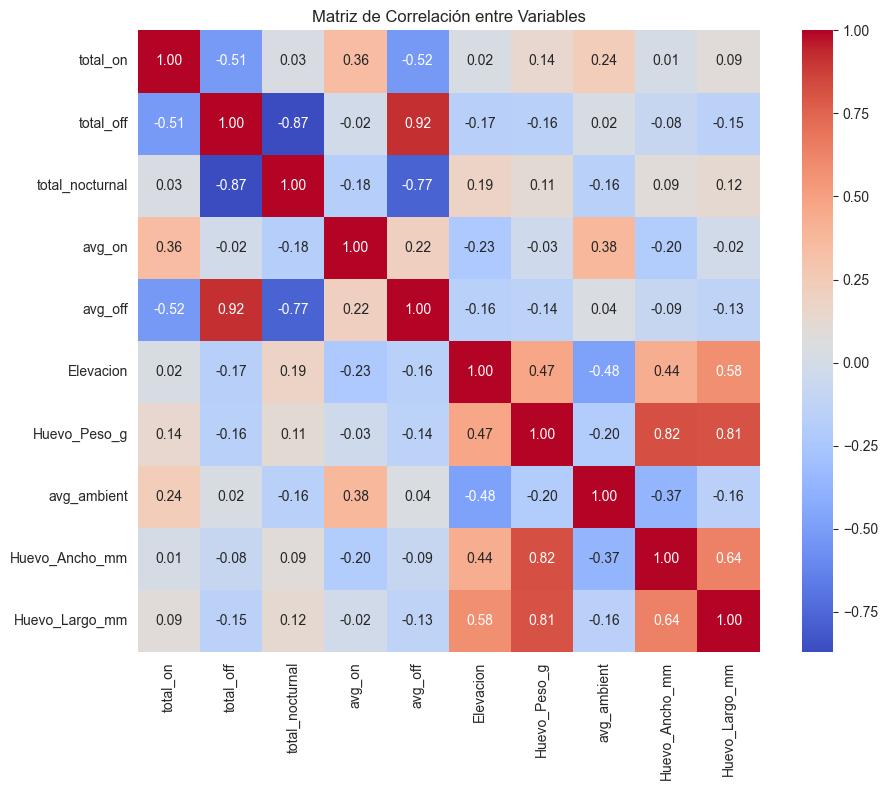

In [51]:
columnas_interes = [
    'total_on', 'total_off', 'total_nocturnal',
    'avg_on', 'avg_off', 'Elevacion', 'Huevo_Peso_g', 'avg_ambient',
    'Huevo_Ancho_mm', 'Huevo_Largo_mm'
]

# Eliminar filas con valores nulos en las columnas de interés
df_corr = resumen_merge[columnas_interes].dropna()

# Calcular matriz de correlación
corr_matrix = df_corr.corr()

# Visualizar con heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Matriz de Correlación entre Variables')
plt.tight_layout()
plt.show()

In [52]:
estadisticas_altura = resumen_merge.groupby('Especie')['Elevacion'].agg(
    Promedio_Elevacion='mean',
    Desviacion_Estandar_Elevacion='std',
    N='count'
).reset_index()

print(estadisticas_altura)

                    Especie  Promedio_Elevacion  \
0  Myioborus_melanocephalus         2723.623377   
1        Myioborus_miniatus         1689.981050   
2         Myioborus_ornatus         2320.000000   

   Desviacion_Estandar_Elevacion    N  
0                     204.460351   66  
1                     446.619375  196  
2                       0.000000    8  


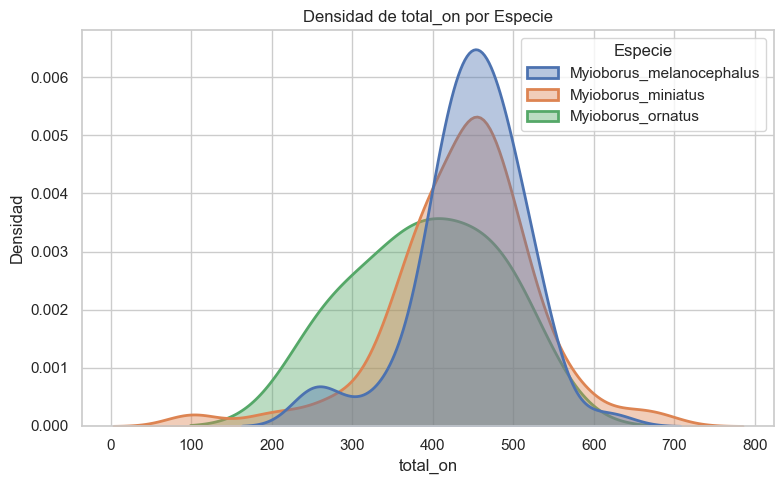

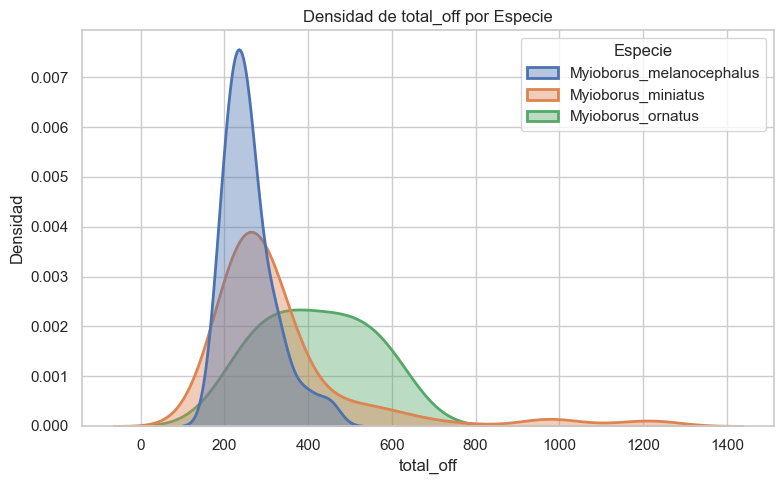

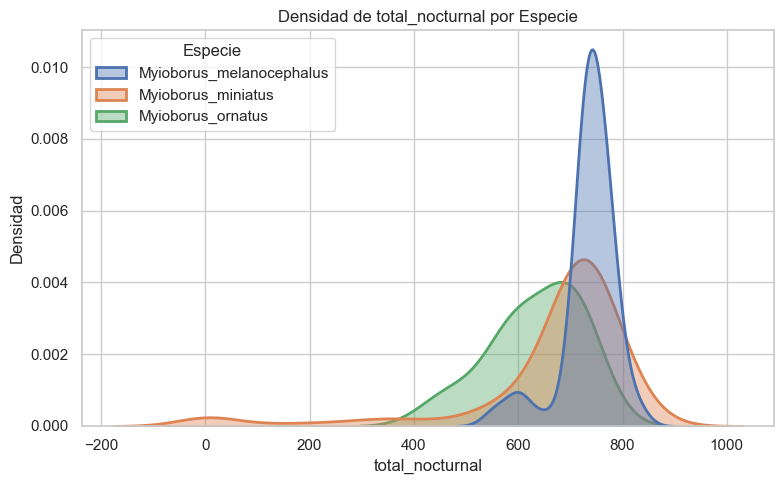

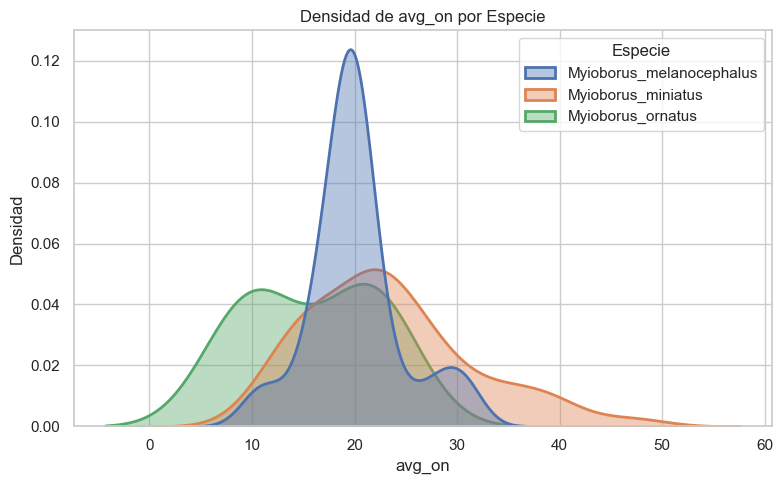

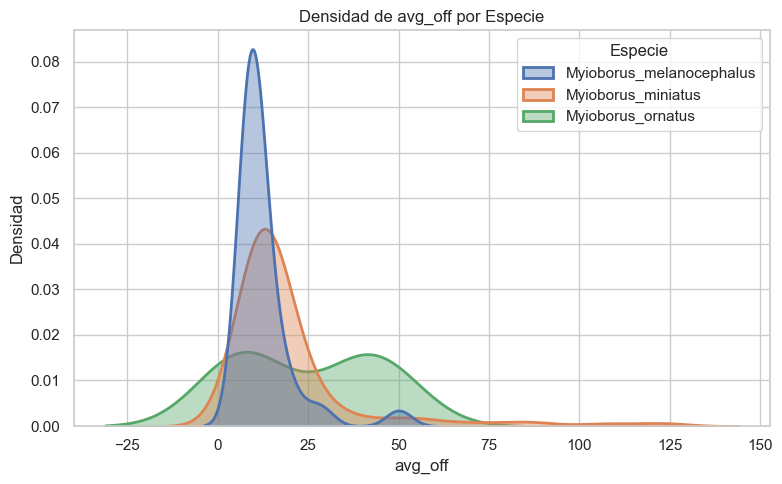

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13004\2368198642.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


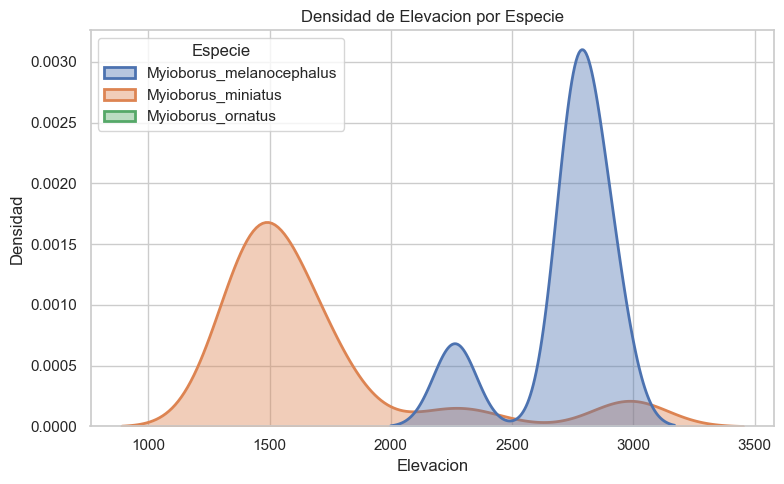

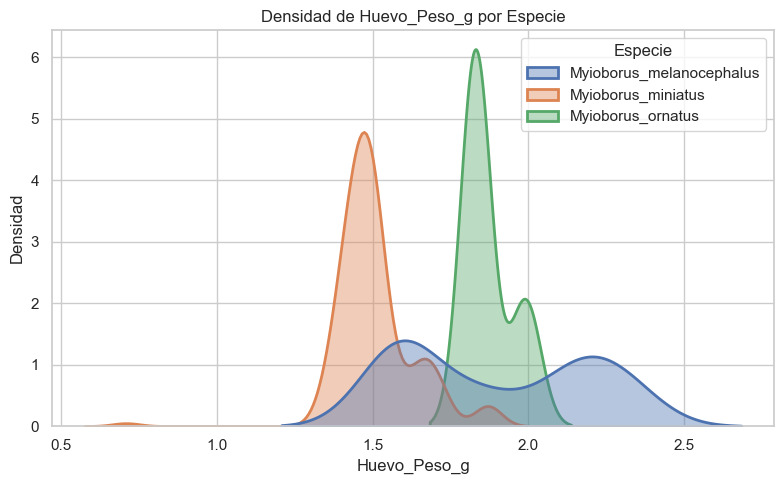

In [53]:
# Variables numéricas a graficar
variables = [
    'total_on', 'total_off', 'total_nocturnal',
    'avg_on', 'avg_off', 'Elevacion', 'Huevo_Peso_g'
]

# Ajustes generales
sns.set(style="whitegrid")

# Crear una curva de densidad por variable
for var in variables:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(
        data=resumen_merge,
        x=var,
        hue='Especie',
        fill=True,  # Rellenar debajo de la curva
        common_norm=False,  # Normalización separada por especie
        alpha=0.4,  # Transparencia
        linewidth=2
    )
    plt.title(f'Densidad de {var} por Especie')
    plt.xlabel(var)
    plt.ylabel('Densidad')
    plt.tight_layout()
    plt.show()

# Deeping into Miyoborus

In [54]:
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [55]:
resumen_merge = resumen_merge[resumen_merge['Especie'] != 'Myioborus_ornatus'].copy()

In [56]:
#resumen_merge

In [57]:
columnas_a_revisar = ['total_on', 'avg_on', 'avg_off', 'Elevacion', 'Huevo_Peso_g', 'avg_ambient']

# Filtrar filas con al menos un NaN en las columnas especificadas
nas_en_columnas = resumen_merge[resumen_merge[columnas_a_revisar].isna().any(axis=1)]

# Mostrar las filas con el ID correspondiente
resultado = nas_en_columnas[['equivalente'] + columnas_a_revisar]
print(resultado)

Empty DataFrame
Columns: [equivalente, total_on, avg_on, avg_off, Elevacion, Huevo_Peso_g, avg_ambient]
Index: []


In [58]:
columnas_pca = [
    'total_on',
    'avg_on', 'avg_off', 'Elevacion', 'Huevo_Peso_g', 'avg_ambient'
]

In [59]:
df_pca = resumen_merge[columnas_pca].dropna()
X_scaled = StandardScaler().fit_transform(df_pca)

In [60]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [61]:
var_exp = pca.explained_variance_ratio_
var_cumsum = np.cumsum(var_exp)

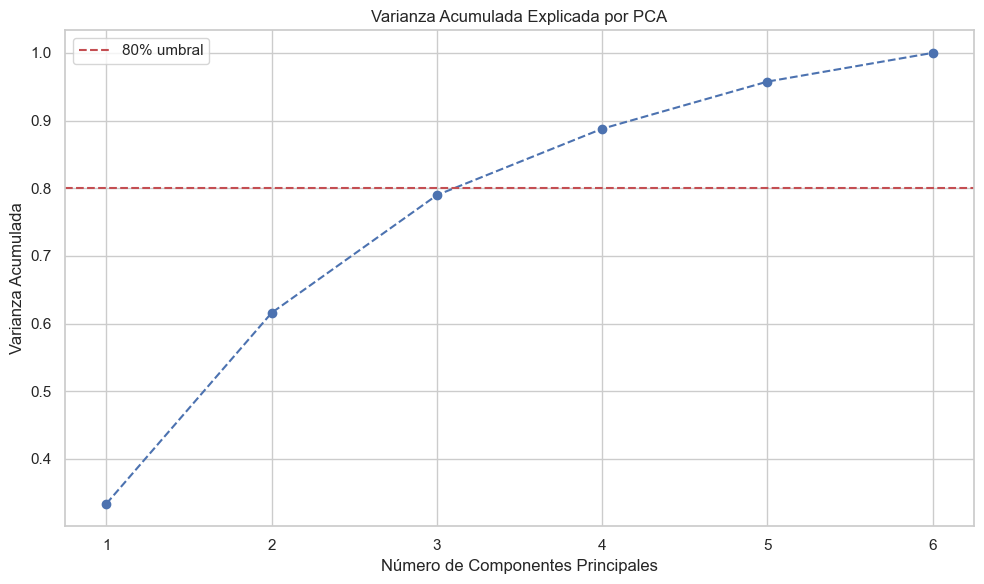

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(var_exp) + 1), var_cumsum, marker='o', linestyle='--')
plt.title('Varianza Acumulada Explicada por PCA')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada')
plt.grid(True)
plt.axhline(0.80, color='r', linestyle='--', label='80% umbral')
plt.legend()
plt.tight_layout()
plt.show()

In [63]:
df_pca = resumen_merge.dropna(subset=columnas_pca + ['Especie']).copy()

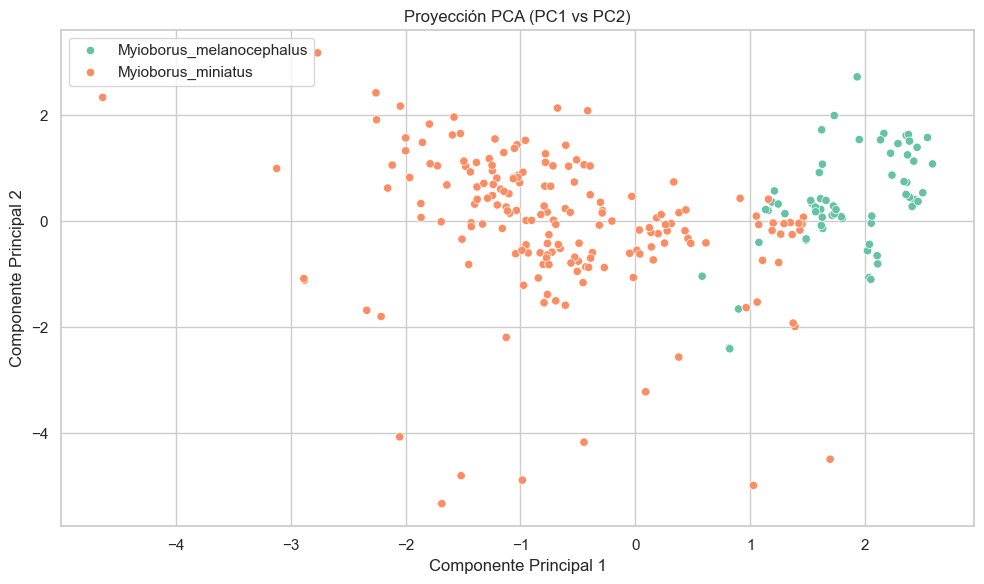

In [64]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# 4. Construir un nuevo DataFrame con los resultados
df_pca_resultado = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
df_pca_resultado['Especie'] = df_pca['Especie'].values

# 5. Visualizar PC1 vs PC2
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca_resultado, x='PC1', y='PC2', hue='Especie', palette='Set2')
plt.title('Proyección PCA (PC1 vs PC2)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.tight_layout()
plt.show()


In [65]:
features = columnas_pca  # Debes haber definido esta lista antes
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2', 'PC3'],
    index=features
)
print(loadings)

                   PC1       PC2       PC3
total_on     -0.060895  0.704130 -0.059075
avg_on       -0.404703  0.304287  0.586628
avg_off      -0.237824 -0.518124  0.573523
Elevacion     0.571098  0.095030  0.269359
Huevo_Peso_g  0.403483  0.281935  0.500155
avg_ambient  -0.535720  0.233752 -0.027208


In [66]:
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {var:.2%} d varianze")

PC1: 33.39% d varianze
PC2: 28.20% d varianze
PC3: 17.39% d varianze


In [67]:
a = 33.39 +28.20+17.39
a

78.98

In [68]:
range_n_clusters = range(2, 11)
inertia = []
silhouette_scores = []

In [69]:
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, labels))

Text(0, 0.5, 'Inertia')

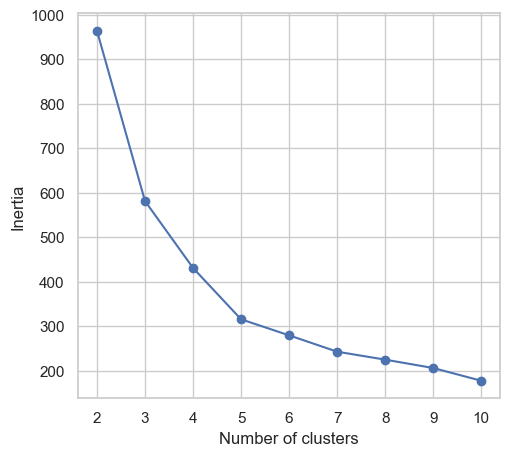

In [70]:
# Gráfico del
plt.figure(figsize=(12, 5))

# Elbow plot
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertia, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")

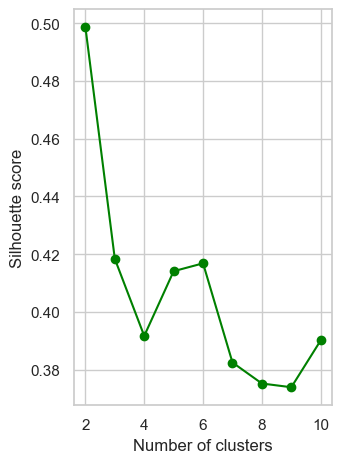

In [71]:
# Silhouette plot
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o', color='green')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")

plt.tight_layout()
plt.show()

In [72]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=30)
labels = kmeans.fit_predict(X_pca)

# Crear DataFrame de resultados
df_pca_resultado = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
df_pca_resultado['cluster'] = labels
df_pca_resultado['Especie'] = resumen_merge['Especie'].values  # asegúrate que index coincida




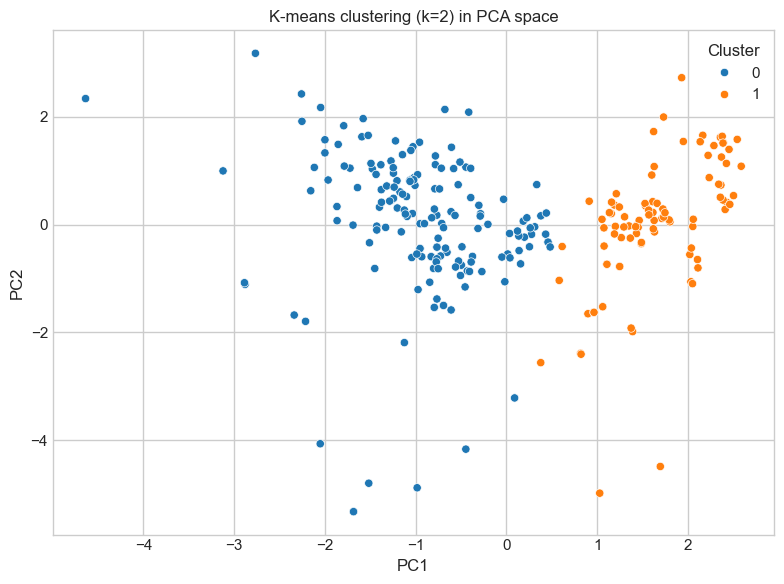

In [73]:
# Graficar clusters en el espacio PCA
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca_resultado, x='PC1', y='PC2', hue='cluster', palette='tab10')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-means clustering (k=2) in PCA space")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

In [74]:
# Asignar los clústeres al DataFrame original
resumen_merge['cluster'] = kmeans.labels_  # Asumiendo....

# columna 'Especie'
df_cluster_analisis = resumen_merge[['cluster', 'Especie']].dropna()

In [75]:
tabla = pd.crosstab(df_cluster_analisis['cluster'], df_cluster_analisis['Especie'])
print(tabla)

Especie  Myioborus_melanocephalus  Myioborus_miniatus
cluster                                              
0                               0                 168
1                              66                  28


In [76]:
from scipy.stats import chi2_contingency

# Prueba de independencia!!!
chi2, p, dof, expected = chi2_contingency(tabla)

print(f"Chi2 = {chi2:.4f}")
print(f"p-value = {p:.4f}")

Chi2 = 153.9740
p-value = 0.0000


In [77]:
cluster_to_especie = {
    0: "Myioborus miniatus",
    1: "Myioborus melanocephalus"
}

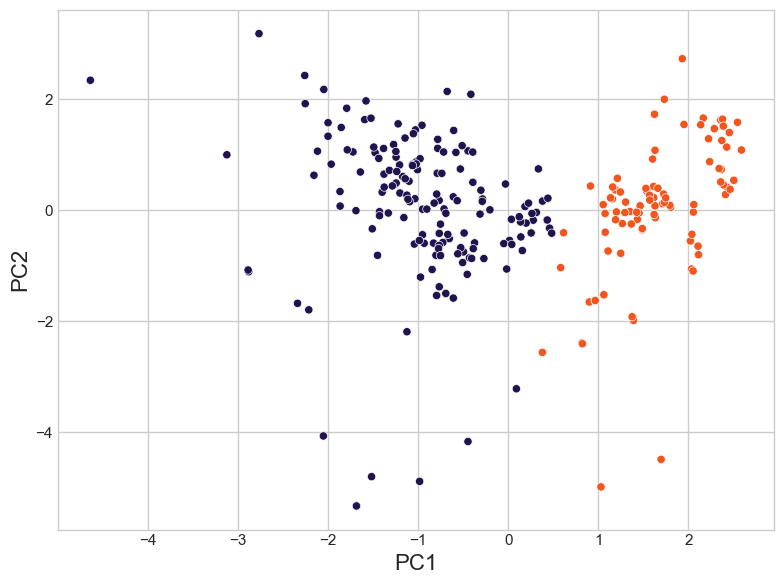

In [78]:
plt.style.use("seaborn-v0_8-whitegrid")
# Crear etiquetas tipo "0 = especie"
df_pca_resultado['cluster_nombre'] = df_pca_resultado['cluster'].map(
    lambda x: f"{x} = {cluster_to_especie[x]}"
)

# Colores personalizados opcionales
colores_personalizados = {
    "0 = Myioborus miniatus": "#21134D",
    "1 = Myioborus melanocephalus": "#F0561D"
}

# Graficar
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_pca_resultado,
    x='PC1', y='PC2',
    hue='cluster_nombre',
    palette=colores_personalizados
)
plt.xlabel("PC1", fontsize=16)
plt.ylabel("PC2", fontsize=16)
plt.legend().remove()
plt.tight_layout()
plt.savefig("figures/Kmeans_species.png", dpi=300)
plt.show()

# direncias especie

In [79]:
from scipy.stats import mannwhitneyu

In [80]:
df_mwu = resumen_merge.dropna(subset=['Especie', 'Huevo_Peso_g'])

# Verifica que solo hay dos especies
print(df_mwu['Especie'].unique())

# Separar los datos por especie
grupo1 = df_mwu[df_mwu['Especie'] == 'Myioborus_miniatus']['Huevo_Peso_g']
grupo2 = df_mwu[df_mwu['Especie'] == 'Myioborus_melanocephalus']['Huevo_Peso_g']

# Test de Mann-Whitney U (no asume distribución normal)
stat, p = mannwhitneyu(grupo1, grupo2, alternative='two-sided')

print(f"Mann-Whitney U statistic: {stat:.4f}")
print(f"P-value: {p:.4f}")

['Myioborus_melanocephalus' 'Myioborus_miniatus']
Mann-Whitney U statistic: 1106.0000
P-value: 0.0000


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13004\2659300011.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


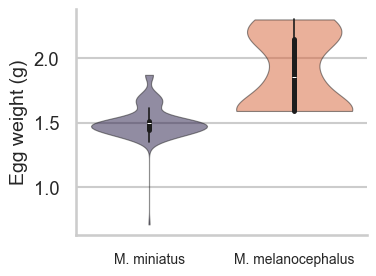

In [81]:
sns.set(style="whitegrid", context="talk", font_scale=0.8)

plt.figure(figsize=(4, 3))

sns.violinplot(
    data=df_mwu,
    x='Especie',
    y='Huevo_Peso_g',
    order=['Myioborus_miniatus', 'Myioborus_melanocephalus'],  # invertir orden
    palette=['#21134D', '#F0561D'],  # también se invierte el orden de colores
    inner='box',
    linewidth=0.8, alpha=0.5,
    cut=0
)

plt.ylabel("Egg weight (g)", fontsize=14)
plt.xlabel("", fontsize=14)

# Etiquetas abreviadas, en el mismo orden que 'order'
plt.xticks(
    ticks=[0, 1],
    labels=["M. miniatus", "M. melanocephalus"],
    fontsize=10
)

sns.despine()
plt.tight_layout()
plt.savefig("figures/Myioborus_egg_vs_sp.png", dpi=300)
plt.show()

In [82]:
resumen_estadistico = df_mwu.groupby('Especie')['Huevo_Peso_g'].agg(['mean', 'std']).round(3)
resumen_estadistico.rename(columns={'mean': 'Mean', 'std': 'SD'}, inplace=True)
print(resumen_estadistico)

                           Mean     SD
Especie                               
Myioborus_melanocephalus  1.894  0.294
Myioborus_miniatus        1.506  0.126


In [83]:
df_mwu_on = resumen_merge.dropna(subset=['Especie', 'avg_on'])
print(df_mwu_on['Especie'].unique())
grupo1 = df_mwu_on[df_mwu_on['Especie'] == 'Myioborus_miniatus']['avg_on']
grupo2 = df_mwu_on[df_mwu_on['Especie'] == 'Myioborus_melanocephalus']['avg_on']
stat, p = mannwhitneyu(grupo1, grupo2, alternative='two-sided')

print(f"Mann-Whitney U statistic: {stat:.4f}")
print(f"P-value: {p:.4f}")

['Myioborus_melanocephalus' 'Myioborus_miniatus']
Mann-Whitney U statistic: 8036.5000
P-value: 0.0032


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13004\2004396398.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


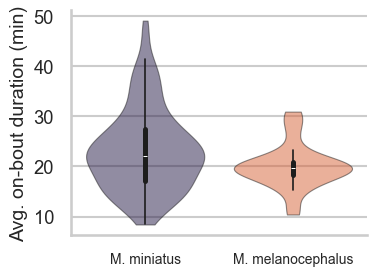

In [84]:
sns.set(style="whitegrid", context="talk", font_scale=0.8)

plt.figure(figsize=(4, 3))

sns.violinplot(
    data=df_mwu,
    x='Especie',
    y='avg_on',
    order=['Myioborus_miniatus', 'Myioborus_melanocephalus'],  # asegurar el orden
    palette=['#21134D', '#F0561D'],
    inner='box',
    linewidth=0.8, alpha=0.5,
    cut=0
)

plt.ylabel("Avg. on-bout duration (min)", fontsize=14)
plt.xlabel("", fontsize=14)

# Etiquetas abreviadas según el nuevo orden
plt.xticks(
    ticks=[0, 1],
    labels=["M. miniatus", "M. melanocephalus"],
    fontsize=10
)

sns.despine()
plt.tight_layout()
plt.savefig("figures/Myioborus_avgOn_vs_sp.png", dpi=300)
plt.show()

In [85]:
resumen_estadistico = df_mwu.groupby('Especie')['avg_on'].agg(['mean', 'std']).round(3)
resumen_estadistico.rename(columns={'mean': 'Mean', 'std': 'SD'}, inplace=True)
print(resumen_estadistico)

                            Mean     SD
Especie                                
Myioborus_melanocephalus  20.059  4.410
Myioborus_miniatus        23.313  8.178


In [86]:
df_mwu_on = resumen_merge.dropna(subset=['Especie', 'avg_off'])
print(df_mwu_on['Especie'].unique())
grupo1 = df_mwu_on[df_mwu_on['Especie'] == 'Myioborus_miniatus']['avg_off']
grupo2 = df_mwu_on[df_mwu_on['Especie'] == 'Myioborus_melanocephalus']['avg_off']
stat, p = mannwhitneyu(grupo1, grupo2, alternative='two-sided')

print(f"Mann-Whitney U statistic: {stat:.4f}")
print(f"P-value: {p:.4f}")

['Myioborus_melanocephalus' 'Myioborus_miniatus']
Mann-Whitney U statistic: 9238.5000
P-value: 0.0000


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13004\1333298126.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


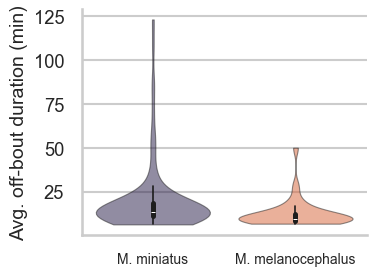

In [87]:
sns.set(style="whitegrid", context="talk", font_scale=0.8)

plt.figure(figsize=(4, 3))

sns.violinplot(
    data=df_mwu,
    x='Especie',
    y='avg_off',
    order=['Myioborus_miniatus', 'Myioborus_melanocephalus'],  # asegurar el orden
    palette=['#21134D', '#F0561D'],
    inner='box',
    linewidth=0.8, alpha=0.5,
    cut=0
)

plt.ylabel("Avg. off-bout duration (min)", fontsize=14)
plt.xlabel("", fontsize=14)

# Etiquetas abreviadas según el orden
plt.xticks(
    ticks=[0, 1],
    labels=["M. miniatus", "M. melanocephalus"],
    fontsize=10
)

sns.despine()
plt.tight_layout()
plt.savefig("figures/Myioborus_avgOff_vs_sp.png", dpi=300)
plt.show()

In [88]:
resumen_estadistico = df_mwu.groupby('Especie')['avg_off'].agg(['mean', 'std']).round(3)
resumen_estadistico.rename(columns={'mean': 'Mean', 'std': 'SD'}, inplace=True)
print(resumen_estadistico)

                            Mean      SD
Especie                                 
Myioborus_melanocephalus  12.582   8.171
Myioborus_miniatus        19.815  19.707


## ecuaciones Myioborus

In [89]:
import itertools

import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools
import warnings
warnings.filterwarnings("ignore")

In [90]:
myoborus = resumen_merge[['Especie', 'Elevacion', 'Huevo_Peso_g', 'avg_ambient', 'total_on',
                          'total_off']].dropna().copy()
myoborus['Especie'] = myoborus['Especie'].astype('category')

In [91]:
variables = ['Elevacion', 'Huevo_Peso_g', 'avg_ambient', 'total_on', 'total_off']

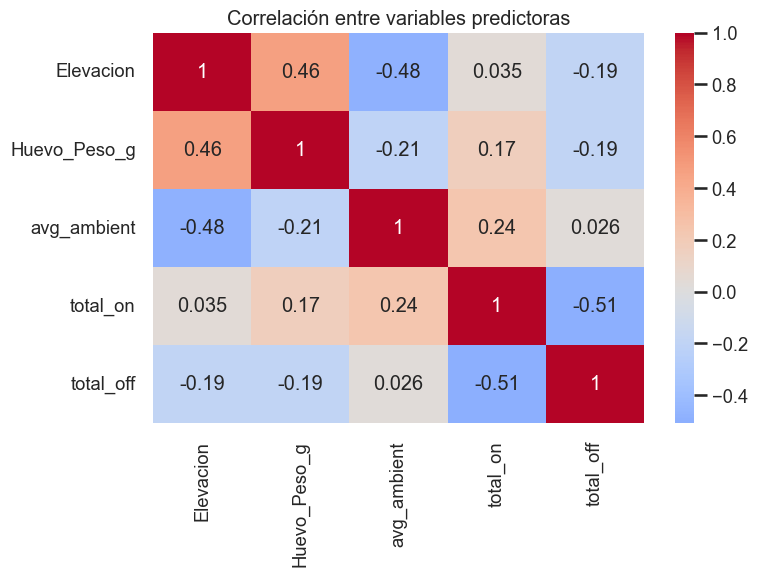

In [92]:
df_cor = myoborus[variables]
plt.figure(figsize=(8, 6))
sns.heatmap(df_cor.corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlación entre variables predictoras")
plt.tight_layout()
plt.show()

In [93]:
#variables = ['Elevacion', 'Huevo_Peso_g', 'avg_ambient', 'avg_on', 'avg_off', 'total_on']


In [94]:
from statsmodels.genmod.families import NegativeBinomial
import itertools
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [95]:
# Variables disponibles
predictors = ['Especie', 'Elevacion', 'Huevo_Peso_g', 'avg_ambient']
y_var = 'total_off'

In [96]:
# Asegúrate de que Especie es categórica
myoborus['Especie'] = myoborus['Especie'].astype('category')

# Almacenar resultados
resultados_nb = []

In [97]:


# Probar con y sin interacciones
for k in range(1, len(predictors) + 1):
    for combo in itertools.combinations(predictors, k):
        pred_str = ' + '.join(combo)

        # Solo efectos principales
        try:
            formula = f"{y_var} ~ {pred_str}"
            model = smf.glm(formula=formula, data=myoborus, family=sm.families.NegativeBinomial())
            result = model.fit()
            y_pred = result.fittedvalues
            mse = mean_squared_error(myoborus[y_var], y_pred)

            resultados_nb.append({
                'formula': formula,
                'mse': mse,
                'aic': result.aic
            })
        except Exception as e:
            print(f"❌ Error en fórmula sin interacción {combo}: {e}")

        # Efectos principales + interacciones a dos vías
        if len(combo) > 1:
            try:
                formula_int = f"{y_var} ~ ({pred_str})**2"
                model_int = smf.glm(formula=formula_int, data=myoborus, family=sm.families.NegativeBinomial())
                result_int = model_int.fit()
                y_pred_int = result_int.fittedvalues
                mse_int = mean_squared_error(myoborus[y_var], y_pred_int)

                resultados_nb.append({
                    'formula': formula_int,
                    'mse': mse_int,
                    'aic': result_int.aic
                })
            except Exception as e:
                print(f"❌ Error en fórmula con interacción {combo}: {e}")

In [98]:
# Crear DataFrame de resultados
#df_resultados_glm = pd.DataFrame(resultados)
df_resultados_nb = pd.DataFrame(resultados_nb)
df_resultados_nb['delta_aic'] = df_resultados_nb['aic'] - df_resultados_nb['aic'].min()
df_resultados_nb = df_resultados_nb.sort_values(by='delta_aic').reset_index(drop=True)


In [99]:
print("\n🏆 Top 5 modelos Negative Binomial GLM con menor ΔAIC:\n")
print(df_resultados_nb[['formula', 'mse', 'aic', 'delta_aic']].head(5))


🏆 Top 5 modelos Negative Binomial GLM con menor ΔAIC:

                                formula           mse          aic  delta_aic
0                   total_off ~ Especie  29474.521021  3545.735490   0.000000
1              total_off ~ Huevo_Peso_g  29468.907248  3546.035749   0.300259
2                 total_off ~ Elevacion  29562.717139  3546.113276   0.377785
3  total_off ~ Elevacion + Huevo_Peso_g  29068.384511  3547.003953   1.268462
4    total_off ~ Especie + Huevo_Peso_g  29233.360636  3547.308743   1.573253


In [100]:
import statsmodels.formula.api as smf

In [101]:
# Fórmula óptima
formula_mejor = "total_off ~ Huevo_Peso_g + Elevacion"

# Ajustar el modelo
modelo_mejor = smf.glm(formula=formula_mejor, data=myoborus, family=NegativeBinomial())
resultado = modelo_mejor.fit()

# Mostrar resumen
print(resultado.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              total_off   No. Observations:                  262
Model:                            GLM   Df Residuals:                      259
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1770.5
Date:                Fri, 13 Jun 2025   Deviance:                       41.856
Time:                        19:02:08   Pearson chi2:                     66.5
No. Iterations:                     6   Pseudo R-squ. (CS):            0.01513
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        6.4554      0.405     15.933   

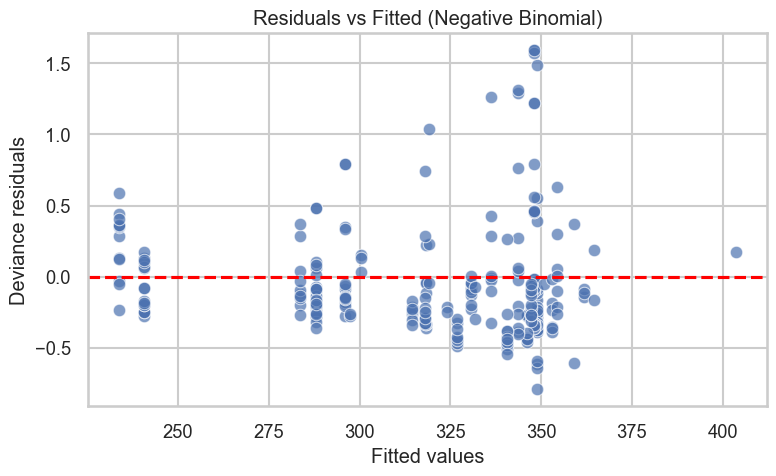

In [102]:
fitted = resultado.fittedvalues
residuals = resultado.resid_deviance

plt.figure(figsize=(8, 5))
sns.scatterplot(x=fitted, y=residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Deviance residuals")
plt.title("Residuals vs Fitted (Negative Binomial)")
plt.tight_layout()
plt.show()

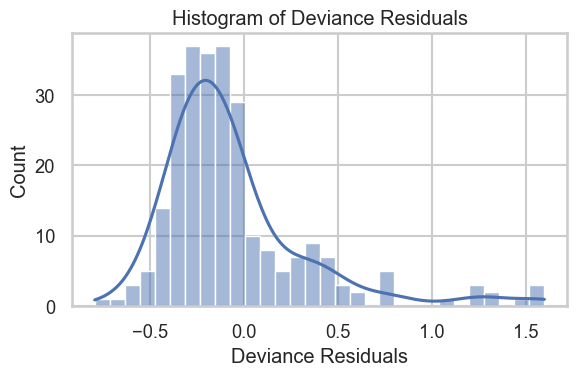

In [103]:
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Histogram of Deviance Residuals")
plt.xlabel("Deviance Residuals")
plt.tight_layout()
plt.show()

In [104]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

modelo_ols = ols(formula=formula_mejor, data=myoborus).fit()
anova_resultado = anova_lm(modelo_ols, typ=2)
print("\n🔍 ANOVA (Type II):\n")
print(anova_resultado)


🔍 ANOVA (Type II):

                    sum_sq     df         F    PR(>F)
Huevo_Peso_g  1.097749e+05    1.0  3.723339  0.054749
Elevacion     1.002980e+05    1.0  3.401903  0.066263
Residual      7.636074e+06  259.0       NaN       NaN


In [105]:
deviance = resultado.deviance
pearson_chi2 = resultado.pearson_chi2
df_resid = resultado.df_resid

dispersion = pearson_chi2 / df_resid
print(f"Dispersion ratio: {dispersion:.2f}")

Dispersion ratio: 0.26


In [106]:
from statsmodels.genmod.families import NegativeBinomial

# Ajustar modelo Negative Binomial
modelo_nb = smf.glm(formula=formula_mejor, data=myoborus, family=NegativeBinomial()).fit()

# Mostrar resultados
print(modelo_nb.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              total_off   No. Observations:                  262
Model:                            GLM   Df Residuals:                      259
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1770.5
Date:                Fri, 13 Jun 2025   Deviance:                       41.856
Time:                        19:02:13   Pearson chi2:                     66.5
No. Iterations:                     6   Pseudo R-squ. (CS):            0.01513
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        6.4554      0.405     15.933   

In [107]:
disp_nb = modelo_nb.pearson_chi2 / modelo_nb.df_resid
print(f"Dispersion ratio (NegBin): {disp_nb:.2f}")

Dispersion ratio (NegBin): 0.26


In [108]:
from pygam import LinearGAM, s
import matplotlib.pyplot as plt
import numpy as np

X = myoborus[['Elevacion']].values
y = myoborus['Huevo_Peso_g'].values

# GAM con menor flexibilidad.....
gam = LinearGAM(s(0, n_splines=5), lam=2).fit(X, y)


XX = gam.generate_X_grid(term=0)
pred = gam.predict(XX)
conf_int = gam.prediction_intervals(XX, width=0.95)

# Graficar


In [109]:
gcv = gam.statistics_['GCV']
print(f"GCV: {gcv:.4f}")

GCV: 0.0496


In [110]:
pseudo_r2 = gam.statistics_['pseudo_r2']['explained_deviance']
print(f"Pseudo R² (explained deviance): {pseudo_r2:.4f}")

Pseudo R² (explained deviance): 0.2172


In [111]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      2.6043
Link Function:                     IdentityLink Log Likelihood:                                 -2111.0987
Number of Samples:                          262 AIC:                                             4229.4061
                                                AICc:                                             4229.535
                                                GCV:                                                0.0496
                                                Scale:                                              0.0487
                                                Pseudo R-Squared:                                   0.2172
Feature Function                  Lam

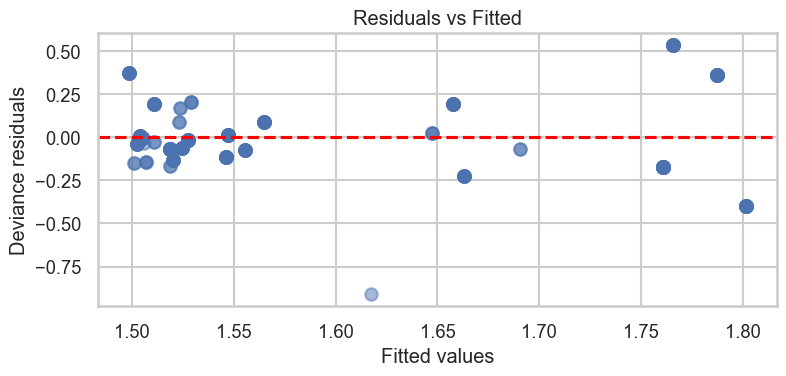

In [112]:
plt.figure(figsize=(8, 4))
plt.scatter(gam.predict(X), gam.deviance_residuals(X, y), alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Deviance residuals')
plt.title('Residuals vs Fitted')
plt.tight_layout()
plt.show()

In [113]:
nombre_legible = {
    "Myioborus_miniatus": "Myioborus miniatus",
    "Myioborus_melanocephalus": "Myioborus melanocephalus"
}
myoborus['Especie_legible'] = myoborus['Especie'].map(nombre_legible)

In [114]:
colores_especie = {
    "Myioborus_miniatus": "#21134D",
    "Myioborus_melanocephalus": "#F0561D"
}

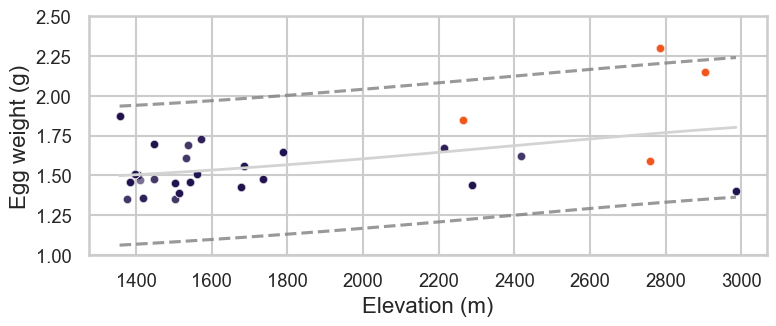

In [115]:
plt.figure(figsize=(8, 3.5))

for especie, color in colores_especie.items():
    especie_legible = nombre_legible[especie]
    subset = myoborus[myoborus['Especie'] == especie]
    plt.scatter(
        subset['Elevacion'], subset['Huevo_Peso_g'],
        facecolors=color,
        edgecolors='white',
        alpha=0.6,
        label=especie_legible,
        linewidth=0.5,
        s=35
    )

# Línea GAM y bandas
plt.plot(XX, pred, color='lightgray', lw=2, label='GAM fit')
plt.plot(XX, conf_int[:, 0], color='gray', linestyle='--', alpha=0.8)
plt.plot(XX, conf_int[:, 1], color='gray', linestyle='--', alpha=0.8)

# Ejes
plt.xlabel('Elevation (m)', fontsize=16)
plt.ylabel('Egg weight (g)', fontsize=16)
plt.ylim(1.0, 2.5)

# Leyenda
#plt.legend()
plt.tight_layout()
plt.savefig("figures/egg_altitude.png", dpi=300)
plt.show()